In [31]:
import os
import tkinter as tk
from tkinter import Text,filedialog
from tkinter import *
import matplotlib.pyplot as plt
import random
import cv2
from PIL import Image,ImageTk
import numpy as np
from keras.models import load_model,save_model,Sequential
from keras.layers import Activation,Conv2D,Dense,Dropout,Flatten,MaxPooling2D
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.callbacks import History

In [32]:
center = 112
upper_bound, lower_bound = 224, 0
pad = 10
region_ul, region_ll = 5000, 150
thresh_ul, thresh_ll = 255, 150
train_data = []
test_data = []
X_train = []
y_train = []
X_test = []
y_test = []
shape = [224,224,3]

In [33]:
train_dir = 'D:/Programs/Python/DATA/SkinCancer/data/train'
test_dir = 'D:/Programs/Python/DATA/SkinCancer/data/test'
Categories = ['benign','malignant']

In [34]:
def initialPrepare(img):
    blur = cv2.medianBlur(img,5)
    img = cv2.cvtColor(blur,cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    _,thresh = cv2.threshold(gray,thresh_ll,thresh_ul,cv2.THRESH_BINARY_INV)
    return thresh

In [35]:
def findDist(x,y):
    X = (center-x)*(center-x)
    Y = (center-y)*(center-y)
    return X+Y

In [36]:
def check(region_size):
    if(region_size>region_ll):
            return True
    return False

In [37]:
def centroid(contour):
    centroidXY = cv2.moments(contour)
    x = int(centroidXY['m10']/centroidXY['m00'])
    y = int(centroidXY['m01']/centroidXY['m00'])
    return x,y

In [38]:
def finalRegion(curr_contour):
    perimeter = cv2.arcLength(curr_contour, True)
    box = cv2.approxPolyDP(curr_contour, 0.02 * perimeter, True)
    x , y , w, h = cv2.boundingRect(box)
    return x, y, w, h

In [39]:
def show_images(y,X_images):
    c = 5
    r = 3
    fig = plt.figure(figsize=(12, 12))
    for i in range(1,r*c+1):
        ax = fig.add_subplot(r,c,i)
        if y[i] == 0:
            ax.title.set_text('Benign')
        else :
            ax.title.set_text('Malignant')
        plt.imshow(X_images[i], interpolation='nearest')
    plt.show()

In [40]:
def preprocess(img):
    thresh=initialPrepare(img)
    _,contours,_ = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

    max_val,curr_contour = 100000,contours[0]
    for contour in contours:
        region_size = cv2.contourArea(contour)
        ok = check(region_size)
        if(ok):
            x,y = centroid(contour)
            distance = findDist(x,y)
            if distance < max_val:
                curr_contour = contour
                max_val = distance
    x_b ,y_b ,w ,h = finalRegion(curr_contour)
    x_f = max(lower_bound,x_b - pad)
    x_fb = min(upper_bound,x_b + w + pad)
    y_f = max(lower_bound,y_b - pad)
    y_fb = min(upper_bound,y_b + h + pad)

    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    final_img = img[y_f:y_fb,x_f:x_fb]
    final_img = cv2.resize(final_img,(224,224))
    return final_img

In [41]:
def prepare_train_data():
    for category in Categories:
        path = os.path.join(train_dir,category)
        cat_idx = Categories.index(category)
        for img in os.listdir(path):
            try:
                image = cv2.imread(os.path.join(path,img))
                image = preprocess(image)
                train_data.append([image,cat_idx])
            except Exception as e:
                pass
prepare_train_data()

In [42]:
random.shuffle(train_data)

In [43]:
for features,labels in train_data:
    X_train.append(features)
    y_train.append(labels)

In [44]:
X_train = np.array(X_train).reshape(-1,shape[0],shape[1],shape[2])
X_train = X_train/255
y_cat_train = to_categorical(y_train,2)

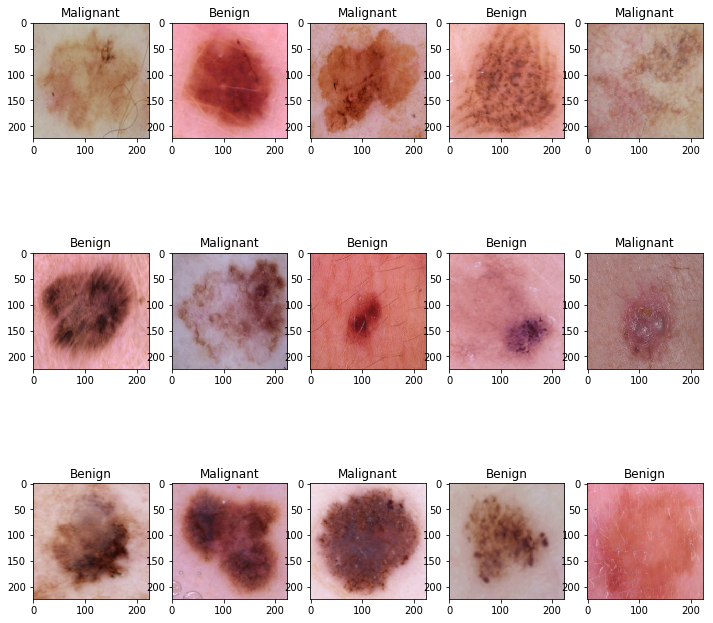

In [45]:
show_images(y_train,X_train)

In [46]:
def prepare_test_data():
    for category in Categories:
        path = os.path.join(test_dir,category)
        cat_idx = Categories.index(category)
        for img in os.listdir(path):
            try:
                image = cv2.imread(os.path.join(path,img))
                image = preprocess(image) 
                test_data.append([image,cat_idx])
            except Exception as e:
                pass
prepare_test_data()

In [47]:
random.shuffle(test_data)

In [48]:
for features,labels in test_data:
    X_test.append(features)
    y_test.append(labels)

In [49]:
X_test = np.array(X_test).reshape(-1,shape[0],shape[1],shape[2])
X_test=X_test/255
y_cat_test = to_categorical(y_test,2)

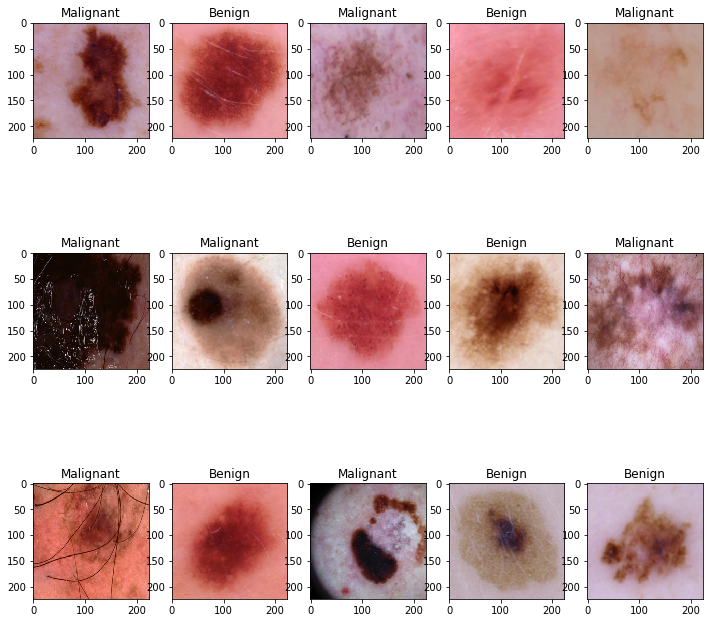

In [50]:
show_images(y_test,X_test)

In [51]:
def train_model():
    model = Sequential()
    model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(224,224,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=(224,224,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=128,kernel_size=(3,3),input_shape=(224,224,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dense(2,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.fit(X_train,y_cat_train,epochs=20,validation_split=0.2)
    return model
model = train_model()

Train on 2108 samples, validate on 528 samples
Epoch 1/20
2108/2108 [==============================] - 297s 141ms/step - loss: 0.5558 - acc: 0.7158 - val_loss: 0.4145 - val_acc: 0.8030
Epoch 2/20
2108/2108 [==============================] - 127s 60ms/step - loss: 0.4463 - acc: 0.7849 - val_loss: 0.3955 - val_acc: 0.8078
Epoch 3/20
2108/2108 [==============================] - 111s 53ms/step - loss: 0.4445 - acc: 0.7623 - val_loss: 0.4193 - val_acc: 0.8191
Epoch 4/20
2108/2108 [==============================] - 114s 54ms/step - loss: 0.4182 - acc: 0.7889 - val_loss: 0.4105 - val_acc: 0.8172
Epoch 5/20
2108/2108 [==============================] - 116s 55ms/step - loss: 0.3857 - acc: 0.8003 - val_loss: 0.3960 - val_acc: 0.8456
Epoch 6/20
2108/2108 [==============================] - 115s 54ms/step - loss: 0.3849 - acc: 0.8098 - val_loss: 0.3883 - val_acc: 0.8239
Epoch 7/20
2108/2108 [==============================] - 114s 54ms/step - loss: 0.3633 - acc: 0.8117 - val_loss: 0.4026 - val_acc: 

In [52]:
model.evaluate(X_test,y_cat_test)

656/656 [==============================] - 51s 77ms/step


[0.45581705904588465, 0.8300304878048781]

In [53]:
def save_model(model):
    model.save('D:\Programs\Python\Projects\Skin-Cancer-Localization-And-Classification\Skin_Cancer(Classification).h5')
save_model(model)

In [54]:
def load_processed_model():
    model = load_model('D:\Programs\Python\Projects\Skin-Cancer-Localization-And-Classification\Skin_Cancer(Classification).h5')
    return model

In [55]:
vis_model=load_processed_model()
vis_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 86528)             0         
__________

In [56]:
root = tk.Tk()
root.title('Skin Cancer Classification')
canvas = Canvas(width=250, height=250, bg='white')
canvas.pack()
root.iconbitmap(r'D:\Photos & Videos\Logo1.ico')

model = load_processed_model()
def Find():
    img_file = filedialog.askopenfilename(title='Select Image',filetypes=[("Image File",'.jpg')])
    img_display = Image.open(img_file)
    pic = ImageTk.PhotoImage(img_display)
    pic_label = Label(canvas,image = pic)
    pic_label.image=pic
    pic_label.grid(row=0,column=0)

    res = image.load_img(img_file,target_size=(224,224))
    res = image.img_to_array(res)
    res = np.expand_dims(res,axis=0)
    res = res/255

    window1  = Toplevel()
    window1.iconbitmap(r'D:\Photos & Videos\Logo1.ico')
    output = model.predict(res)
    print(output)
    if(output[0][0]>output[0][1]):
        text1="Chances of Cancer " + str(round(100-output[0][0]*100,2))+"%"
        lbl = Label(window1,text=text1).pack()
    else:
        text2="Chances of Cancer " + str(round(output[0][1]*100,2)) +"%"
        lbl = Label(window1,text=text2).pack()
openfile = tk.Button(root,text="Open Image",padx=10,pady=5,fg="black",command = Find)
openfile.pack()
root.mainloop()

[[1.00000e+00 2.27419e-09]]
[[9.99849081e-01 1.08006396e-04]]
[[1.00000e+00 8.28188e-13]]
[[0.87886673 0.16770254]]
[[9.9988103e-01 4.6689576e-05]]
[[3.1533924e-05 9.9997258e-01]]
[[9.437987e-05 9.998952e-01]]
